# Progetto di Machine Learning 2023

Il presente progetto riguarda la predizione dei prezzi delle case.

In [39]:
from feature_selection import *
from model_selection import *
from models import *
from grafici import *
from dataset import *
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List, Tuple, Dict
from pprint import pprint


In [40]:
from sklearn.model_selection import train_test_split


initial_training_set = pd.read_csv('../dataset/train.csv')

In [41]:
initial_training_set.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Suddividiamo il training e il testing set

# 1. Data cleaning
Analizziamo il dataset per eliminare i valori nulli. In particolare adottiamo la seguente politica:
- se i valori nulli sono maggiori del 80% degli elementi del training set, eliminiamo la feature.
- altrimenti, se la feature è numerica, sostituiamo il valore nullo con il valore medio.
- altrimenti, se la feature è categorica, sostituiamo il valore nullo con il valore più comune.

Questo passaggio è necessario per il corretto funzionamento dei metodi di feature selection, feature extraction e per i modelli di machine learning che utilizzeremo.

## Rimozione delle colonne con molti valori nulli
Innanzitutto realizziamo un grafico con le features che hanno almeno un valore nullo:

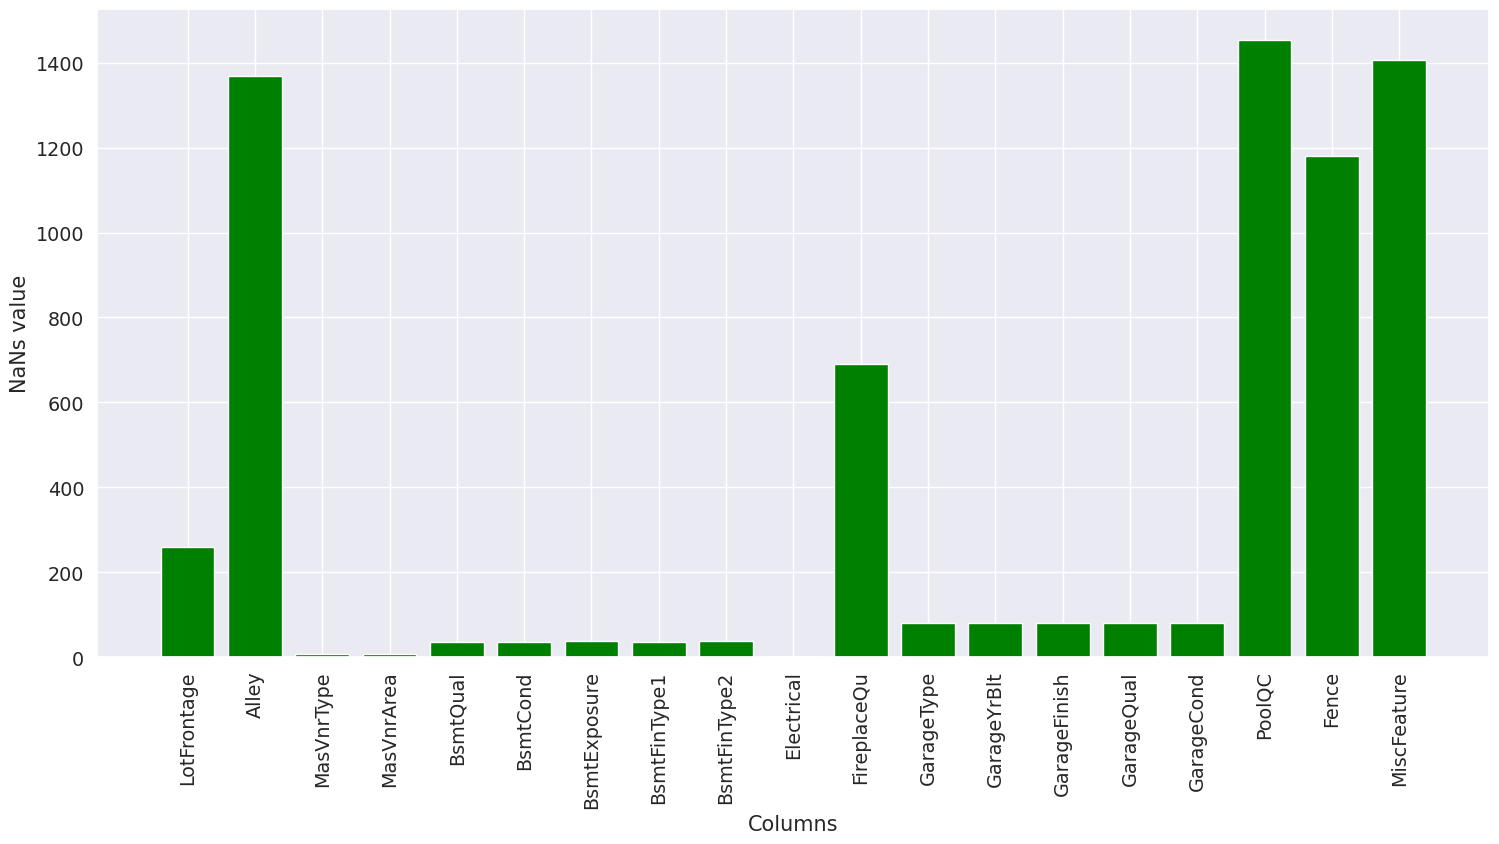

Colonne con valori nulli:  19


In [42]:
def get_nan_cols(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Index]:
    """ Restituisce:
        0: un dataframe con nome colonna, numero null
        1: una lista (Index) con i nomi delle colonne che hanno valori nulli
    """
    count_nan = dataset.isnull().sum(axis=0)
    columns_with_nan_df = count_nan.loc[count_nan != 0]
    nan_cols_names = dataset.columns[dataset.isna().any()]
    return columns_with_nan_df, nan_cols_names

def get_cols_with_nan_number(dataset: pd.DataFrame) -> int:
    print("Colonne con valori nulli: ", len(get_nan_cols(dataset)[1].to_list()))

def check_nan_value(dataset):
    # Verifichiamo se ci sono valori NaN
    columns_with_nan_df, nan_cols_names = get_nan_cols(dataset)
    pd.DataFrame(data=nan_cols_names)
    plt.figure(figsize=(16,8))
    plt.bar(nan_cols_names, columns_with_nan_df, color="green")
    plt.xlabel("Columns")
    plt.xticks(rotation=90)
    plt.ylabel("NaNs value")
    plt.show()

check_nan_value(initial_training_set)
get_cols_with_nan_number(initial_training_set)

Notiamo che ci sono 19 colonne che hanno almeno un valore nullo. In particolare: **Alley**, **PoolQC**, **Fence** e **MiscFeature** hanno più dell'85% di valori nulli, quindi le **eliminiamo**

Numero di valori non nulli minimo:  293


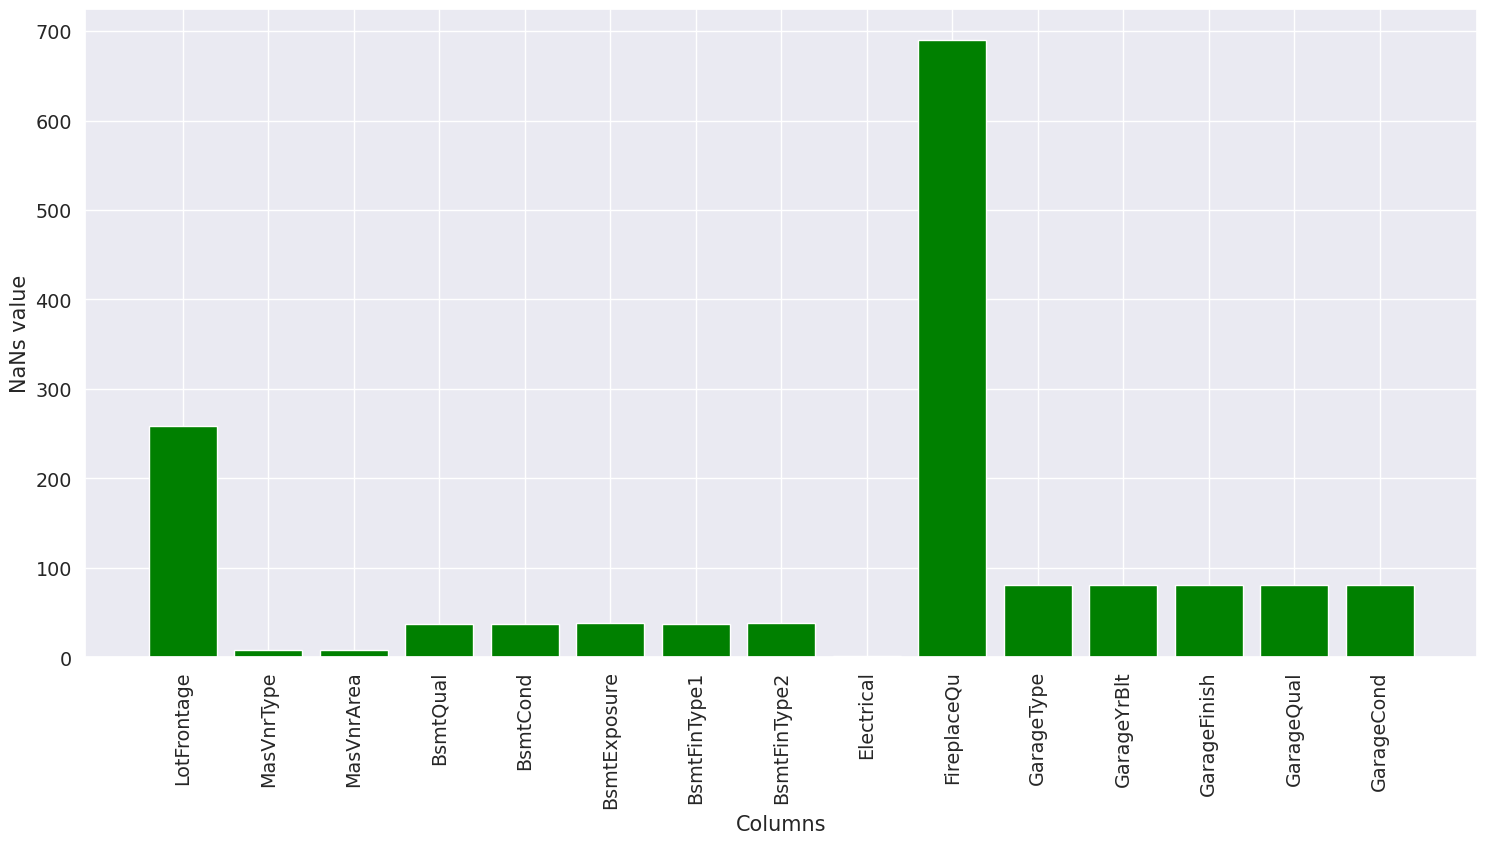

Colonne con valori nulli:  15


In [43]:
def remove_nan_columns(dataset: DataFrame, threshold=20) -> DataFrame:
        """Elimina colonne con valori NaN quando i valori Nan sono superiori a [threshold]%"""
        thresh = int((len(dataset) * threshold) / 100) + 1
        print("Numero di valori non nulli minimo: ", thresh)
        # axis: specifichiamo di eliminare solo le colonne; thresh: numero minimo per eliminare
        dataset.dropna(axis='columns', thresh=thresh, inplace=True)
        return dataset

initial_training_set2 =  remove_nan_columns(initial_training_set)
check_nan_value(initial_training_set2) # senza troppi valori nulli
get_cols_with_nan_number(initial_training_set2)

## Sostituzione dei valori nulli nelle feature numeriche

Per prima cosa prendiamo le feature numeriche

In [44]:
numerical_cols = initial_training_set2.select_dtypes(include='number').columns.to_list()
numerical_train = initial_training_set2[numerical_cols]
print(numerical_cols)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


Sostituiamo alle colonne numeriche del training set `initial_training_set2` a cui abbiamo eliminato le colonne con oltre l'80% dei valori nulli, la media dei valori al posto dei rimanenti valori NaN

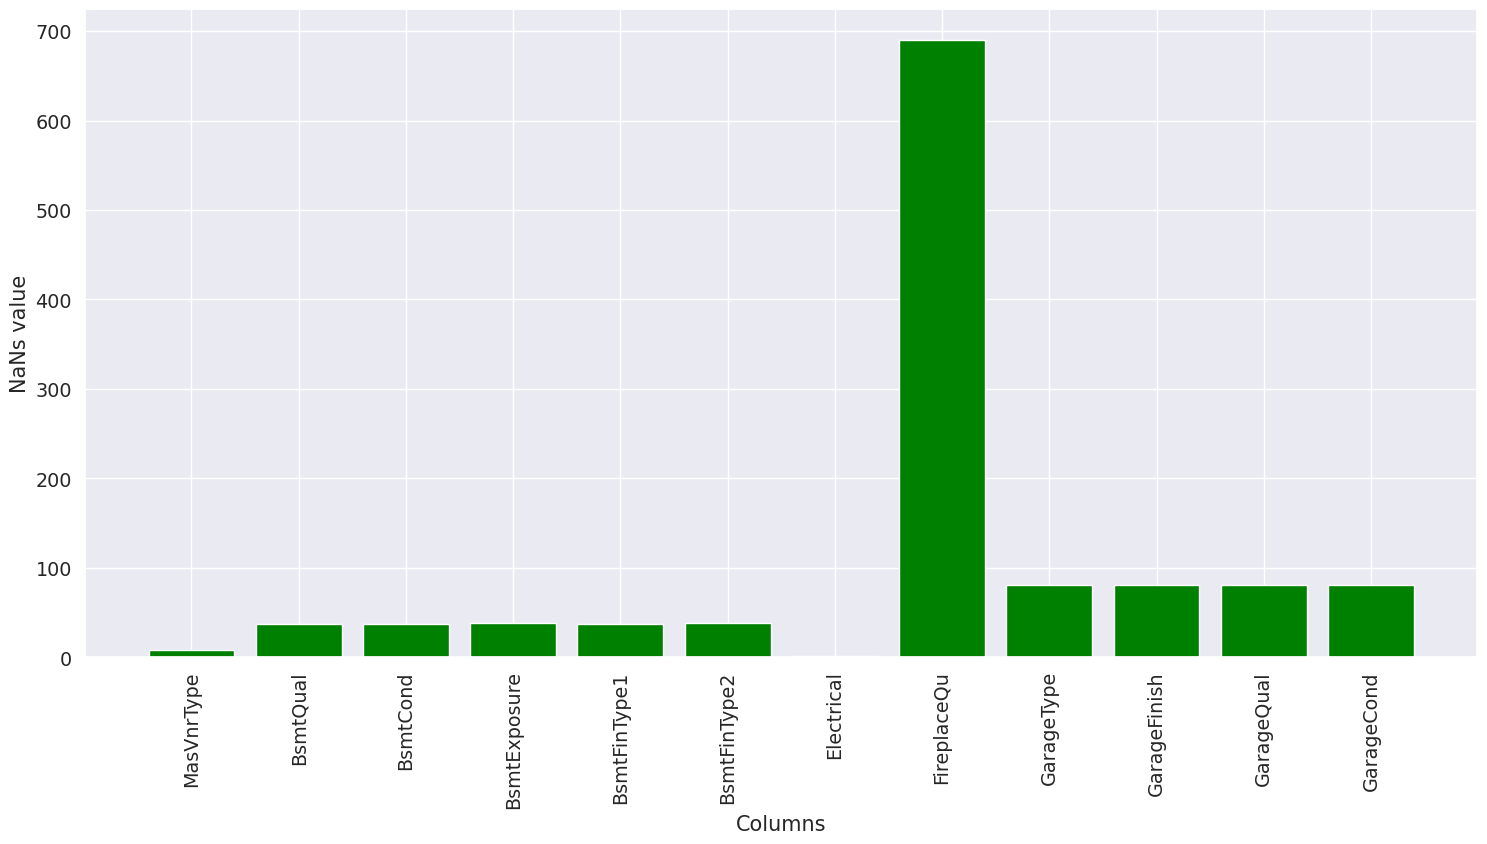

Colonne con valori nulli:  12


In [45]:
initial_training_set2 = initial_training_set2.fillna(initial_training_set2[numerical_cols].mean())
check_nan_value(initial_training_set2) # senza troppi valori nulli
get_cols_with_nan_number(initial_training_set2)

## Sostituzione dei valori nulli nelle feature categoriche

Per prima cosa prendiamo le colonne categoriche

In [46]:
categorical_cols = initial_training_set2.select_dtypes(include='object').columns.to_list()
categorical_train = initial_training_set2[categorical_cols]
print(categorical_cols)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


Sostituiamo alle colonne **categoriche** del training set `initial_training_set2` a cui abbiamo eliminato le colonne con oltre l'80% dei valori nulli e i valori nulli delle colonne numeriche, la moda dei valori al posto dei rimanenti valori NaN.

In [47]:
mode = categorical_train.mode()
print("Valori più frequenti", mode.iloc[0], "\n\n")
initial_training_set2 = initial_training_set2.fillna(mode.iloc[0])
get_cols_with_nan_number(initial_training_set2)

Valori più frequenti MSZoning              RL
Street              Pave
LotShape             Reg
LandContour          Lvl
Utilities         AllPub
LotConfig         Inside
LandSlope            Gtl
Neighborhood       NAmes
Condition1          Norm
Condition2          Norm
BldgType            1Fam
HouseStyle        1Story
RoofStyle          Gable
RoofMatl         CompShg
Exterior1st      VinylSd
Exterior2nd      VinylSd
MasVnrType          None
ExterQual             TA
ExterCond             TA
Foundation         PConc
BsmtQual              TA
BsmtCond              TA
BsmtExposure          No
BsmtFinType1         Unf
BsmtFinType2         Unf
Heating             GasA
HeatingQC             Ex
CentralAir             Y
Electrical         SBrkr
KitchenQual           TA
Functional           Typ
FireplaceQu           Gd
GarageType        Attchd
GarageFinish         Unf
GarageQual            TA
GarageCond            TA
PavedDrive             Y
SaleType              WD
SaleCondition     Normal
Name

# Preprocessing
Trasformiamo tutte le colonne categoriche in numeriche.
- Se la colonna categorica rappresenta una valutazione, usiamo l'ordinal encoding
- Altrimenti usiamo one-hot encoding (one-of-k). In tal caso le feature aumenteranno quindi bisogna controllare il numero di colonne finale.

Per prima cosa determiniamo le colonne categoriche che vanno trasformate con l'**ordinal encoding** e quelle che vanno trasformate con l'one hot encoding, a partire dal file `valutazioneFeature.csv`.

In [48]:
ordinal_enc_cols = [
    "ExterQual",
    "KitchenQual",
    "ExterCond",
    "HeatingQC",
    "BsmtCond",
    "BsmtFinType1",
    "BsmtFinType2",
    "GarageCond",
    "BsmtExposure",
    "GarageQual",
    "FireplaceQu",
    "BsmtQual"
]

onehot_enc_cols = [
    "MSZoning",
    "Condition1",
    "Electrical",
    "Functional",
    "Utilities",
    "Condition2",
    "Exterior1st",
    "BldgType",
    "CentralAir",
    "Exterior2nd",
    "Heating",
    "HouseStyle",
    "RoofMatl",
    "Street",
    "LotConfig",
    "Neighborhood",
    "LandSlope",
    "Foundation",
    "LandContour",
    "MasVnrType",
    "PavedDrive",
    "RoofStyle",
    "SaleType",
    "GarageFinish",
    "GarageType",
    "LotShape",
    "SaleCondition"
]

Eseguiamo prima l'ordinal encoding:

In [49]:
def ordinal_encoding(dataset: DataFrame, ord_enc_cols: List[str]) -> DataFrame:
        # applica l'ordinal Encoding alle colonne categoriche che rappresentano una valutazione
        copy = dataset.copy()
        for cat in ord_enc_cols:
            copy[cat], _ = pd.factorize(dataset[cat])

        return copy

initial_training_set3 = ordinal_encoding(initial_training_set2, ordinal_enc_cols)

print("Alcune delle colonne prima e dopo l'ordinal encoding")
print(initial_training_set2[ordinal_enc_cols[:3]])
print(initial_training_set3[ordinal_enc_cols[:3]])

Alcune delle colonne prima e dopo l'ordinal encoding
     ExterQual KitchenQual ExterCond
0           Gd          Gd        TA
1           TA          TA        TA
2           Gd          Gd        TA
3           TA          Gd        TA
4           Gd          Gd        TA
...        ...         ...       ...
1455        TA          TA        TA
1456        TA          TA        TA
1457        Ex          Gd        Gd
1458        TA          Gd        TA
1459        Gd          TA        TA

[1460 rows x 3 columns]
      ExterQual  KitchenQual  ExterCond
0             0            0          0
1             1            1          0
2             0            0          0
3             1            0          0
4             0            0          0
...         ...          ...        ...
1455          1            1          0
1456          1            1          0
1457          2            0          1
1458          1            0          0
1459          0            1          

Ora eseguiamo il one hot encoding. Il numero iniziale di colonne è:

In [50]:
initial_training_set3.shape[1]

77

In [51]:
def one_hot_encoding(dataset: DataFrame, one_hot_cols: List[str]) -> DataFrame:
    """
    Mappa le features categoriche in nuove colonne in formato one-hot
    :param dataset: self.train o self.test
    :return: il DataFrame di train o test con le stringhe trasformate in ulteriori colonne one-hot (con i nomi)
    """
    
    copy = dataset.copy()
    
    # applica il One Hot Encoding alle colonne categoriche
    encoded_df = pd.get_dummies(dataset[one_hot_cols])

    # aggiunge il prefisso al nome delle colonne
    prefix_dict = {col: f"{col}_{val}" for col in one_hot_cols for val in dataset[col].unique()}

    encoded_df.add_prefix('').rename(columns=prefix_dict)

    only_non_one_hot = copy.drop(columns=one_hot_cols, axis=1)
    result_df = pd.concat([only_non_one_hot, encoded_df], axis=1)

    return result_df

initial_training_set4 = one_hot_encoding(initial_training_set3, one_hot_cols=onehot_enc_cols)
initial_training_set4.to_csv("../dataset/train_encoded.csv", index=False)
print(initial_training_set4.shape[1])

232


Notiamo che il numero di colonne è passato da 77 a 232. Quindi in seguito sarà necessario determinare quali colonne sono più informative rispetto alla variabile target SalePrice.

# Suddivisione training - testing set

In [52]:
initial_X = initial_training_set4.iloc[:, 1:-1] # tutte le colonne tranne l'ultima
initial_y = initial_training_set4.iloc[:, -1] # solo l'ultima colonna
X_train, X_test, y_train, y_test = train_test_split(initial_X, initial_y, test_size=0.2, random_state=42)

print(f"shape train X: {X_train.shape}") 
print(f"shape train y: {y_train.shape}") 
print(f"shape test X: {X_test.shape}") 
print(f"shape test y: {y_test.shape}") 

shape train X: (1168, 230)
shape train y: (1168,)
shape test X: (292, 230)
shape test y: (292,)


# Confronto features numeriche
Sono state confrontate tutte le feature con il target. Per i dettagli fare riferimento ai file dataset/valutazioneFeatures.csv e valutazioneFeatures.ipynb. Le feature più importanti sono le seguenti:

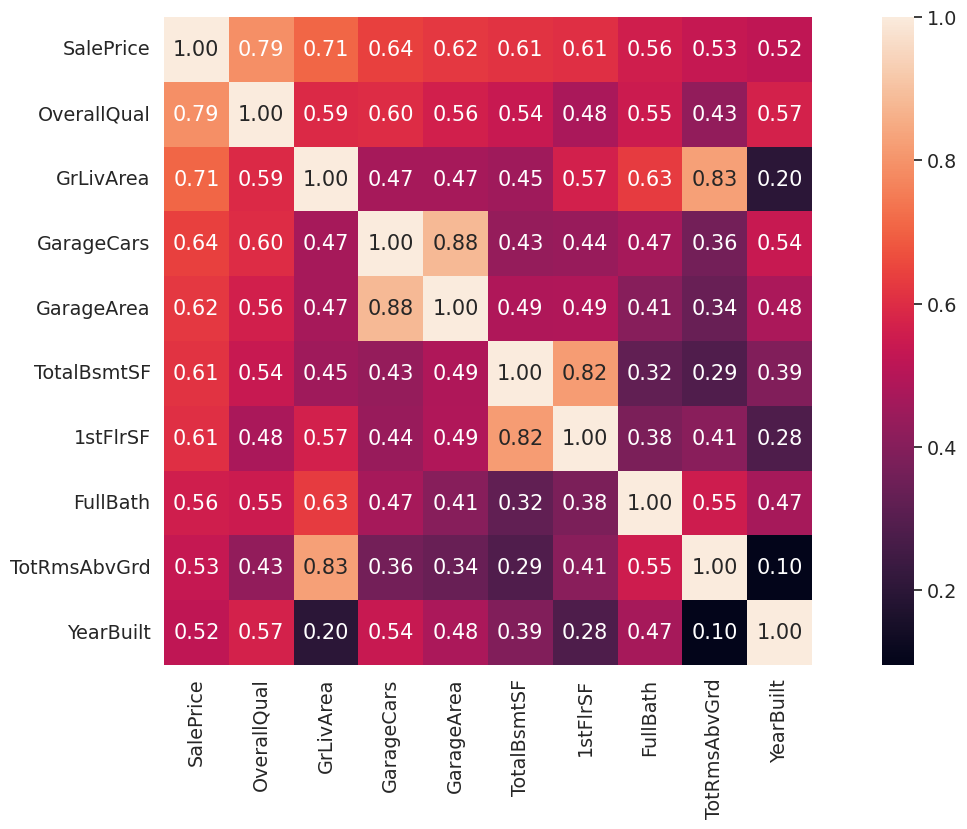

In [53]:
def correlation_matrix_plot(df_train: DataFrame, k=10):
    # saleprice correlation matrix
    corrmat = df_train.corr()
    cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(df_train[cols].values.T)
    sns.set(font_scale=1.25)
    sns.heatmap(cm, 
                cbar=True, # mostra la legenda a destra
                annot=True, # mostra i valori nelle celle
                square=True, # se True mostra il grafico come un quadrato 
                fmt='.2f', # formatta il numero di cifre decimali delle 'annot'
                yticklabels=cols.values, # mostra le label dell'asse y
                xticklabels=cols.values  # mostra le label dell'asse x
    )
    plt.show()

correlation_matrix_plot(initial_training_set4, k=10)

Analizziamo la heatmap:
- Sulla diagonale c'è sempre 1 perché le features sono in correlazione con loro stesse.
- La feature più importante è **OverallQual** con correlazione 0.79 rispetto al SalePrice.
- Garage Cars e Garage Area sono molto correlate tra loro, quindi si può mantenere solamente quella che è più correlata con il SalePrice, ovvero **GarageCars**.
- TotRmsAbvGrd e GrLivArea sono anche loro molto correlate tra loro, la più importante però è **GrLivArea**.
- 1stFlrSF è correlata con **TotalBsmtSF**, ma è più importante quest'ultima.

Per essere più precisi, visualizziamo la heatmap con le sole feature che hanno valore di correlazione con almeno un altra feature superiore a una certa soglia. 

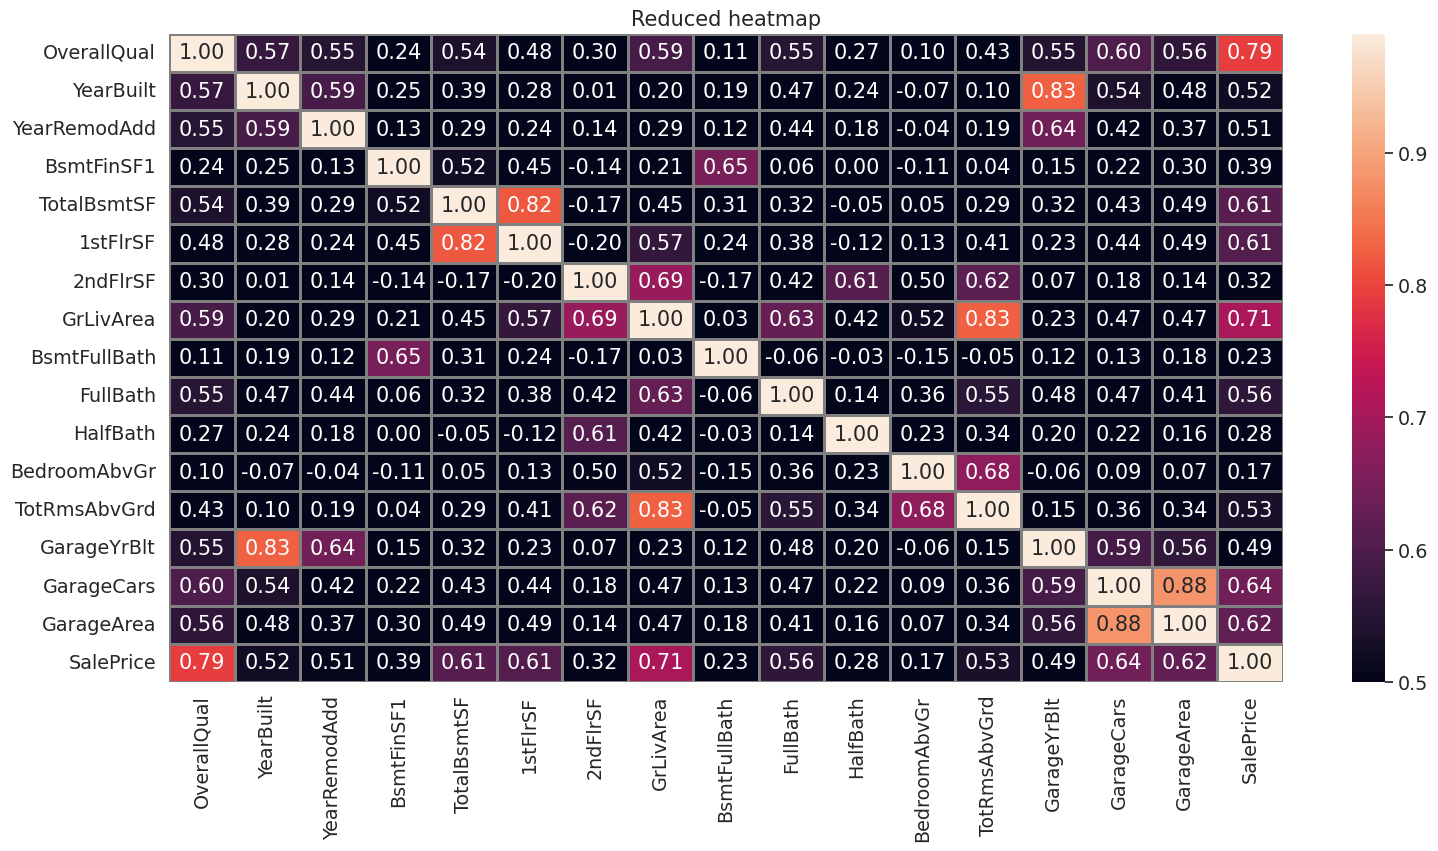

In [54]:
def correlazione_matrice(df_train: DataFrame, threshold: float, val_max: float):
    """Calcola la matrice di correlazione (ndarray) a partire da un dataframe di feature tutte numeriche"""
    corr = df_train.corr().to_numpy()
    # seleziona gli elementi che sono compresi tra il threshold e un valore massimo
    ind_x, = np.where(np.all(np.logical_or(corr < threshold, corr > val_max), axis=0))
    corr = np.delete(corr, ind_x, 1)  # si eliminano

    # stessa cosa per le righe
    ind_y, = np.where(np.all(np.logical_or(corr < threshold, corr > val_max), axis=1))
    corr = np.delete(corr, ind_y, 0)
    # si aggiornano le colonne selezionando solamente quelle filtrate

    return corr, ind_x, ind_y

def correlation_matrix_filtered_plot(df_train: DataFrame, threshold=0.6):
        # threshold: valore minimo di correlazione da considerare
        val_max = 0.99
        # si selezionano le colonne
        labels = df_train.columns
        corr, ind_x, ind_y = correlazione_matrice(df_train, threshold, val_max)
        # si aggiornano le colonne selezionando solamente quelle filtrate
        map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]
        map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]
        # plot heatmap
        heatmap = sns.heatmap(corr, annot=True, fmt='.2f',
                              xticklabels=map_labels_x,
                              yticklabels=map_labels_y,
                              vmin=threshold,
                              vmax=val_max,
                              linewidths=1.0,
                              linecolor="grey")

        heatmap.set_title("Reduced heatmap")
        plt.show()

correlation_matrix_filtered_plot(numerical_train, 0.5)

Ora troviamo le coppie feature con correlazione maggiore di 0.6 e prendiamo anche il valore di correlazione di ciascuna con il SalePrice:

In [94]:
def correlazione_dataframe(df_train, threshold, val_max):
    # si selezionano le colonne
    labels = df_train.columns

    corr, ind_x, ind_y = correlazione_matrice(df_train, threshold, val_max)
    map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]
    map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]

    return pd.DataFrame(corr, columns=map_labels_x, index=map_labels_y)


class Correlazione:
    def __init__(self, feature1, feature2, correlazione, correlazione_f1_target, correlazione_f2_target):
        self.feature1 = feature1
        self.feature2 = feature2
        self.correlazione = correlazione
        self.correlazione_f1_target = correlazione_f1_target
        self.correlazione_f2_target = correlazione_f2_target

    def __str__(self):
        return f"({self.feature1, self.feature2, self.correlazione, self.correlazione_f1_target, self.correlazione_f2_target})"

    def __repr__(self):
        return f"({self.feature1, self.feature2, self.correlazione, self.correlazione_f1_target, self.correlazione_f2_target})"

    def __gt__(self, other):
        return self.correlazione > other.correlazione
    
    def __lt__(self, other):
        return self.correlazione < other.correlazione

def feature_in_correlazione(corr: DataFrame, thresh: float) -> List[Correlazione]:
    colonne = corr.columns
    corr_list = []
    target_index = len(colonne) - 1
    # per ogni riga del dataframe della matrice di correlazione
    for (i, r) in enumerate(corr):
        # e per ogni colonna
        for (j, c) in enumerate(corr[r]):
            # se una coppia di feature diverse ha correlazione elevata, la aggiungiamo alla lista
            if c > thresh and i != j and colonne[i] != "SalePrice" and colonne[j] != "SalePrice":
                # calcoliamo la correlazione delle due feature con la colonna target
                corr_f1_target = corr.iloc[i, target_index]
                corr_f2_target = corr.iloc[j, target_index]
                corr_list.append(Correlazione(colonne[i], colonne[j], c, corr_f1_target, corr_f2_target))

    corr_list.sort()
    return corr_list

min_correlation = 0.6
# trasformo la matrice di correlazione di tutto il dataset in un dataframe
corr = correlazione_dataframe(numerical_train, min_correlation, 0.99)
# poi stampo la lista di feature in correlazione
feature_correlate = feature_in_correlazione(corr, min_correlation)
pprint(feature_correlate)


[(('OverallQual', 'GarageCars', 0.6006707165907149, 0.7909816005838053, 0.6404091972583519)),
 (('GarageCars', 'OverallQual', 0.6006707165907149, 0.6404091972583519, 0.7909816005838053)),
 (('2ndFlrSF', 'HalfBath', 0.6097073002717436, 0.31933380283206736, 0.28410767559478256)),
 (('HalfBath', '2ndFlrSF', 0.6097073002717436, 0.28410767559478256, 0.31933380283206736)),
 (('2ndFlrSF', 'TotRmsAbvGrd', 0.6164226354915431, 0.31933380283206736, 0.5337231555820284)),
 (('TotRmsAbvGrd', '2ndFlrSF', 0.6164226354915431, 0.5337231555820284, 0.31933380283206736)),
 (('GrLivArea', 'FullBath', 0.6300116462511148, 0.7086244776126515, 0.5606637627484453)),
 (('FullBath', 'GrLivArea', 0.6300116462511148, 0.5606637627484453, 0.7086244776126515)),
 (('YearRemodAdd', 'GarageYrBlt', 0.6422767797035356, 0.5071009671113866, 0.4863616774878596)),
 (('GarageYrBlt', 'YearRemodAdd', 0.6422767797035356, 0.4863616774878596, 0.5071009671113866)),
 (('BsmtFinSF1', 'BsmtFullBath', 0.6492117535742649, 0.386419806242153

Quindi troviamo le feature che hanno correlazione maggiore con il SalePrice:

In [95]:
best_features = set()
worst_features = set()
for c in feature_correlate:
    c: Correlazione = c
    if c.correlazione_f1_target > c.correlazione_f2_target:
        best_features.add((c.feature1, c.correlazione_f1_target))
        worst_features.add(c.feature2)
    else:
        best_features.add((c.feature2, c.correlazione_f2_target))
        worst_features.add(c.feature1)
best_features_list = list(best_features)
worst_features_list = list(worst_features)
best_features_list.sort(key=lambda x: x[1], reverse=True)
pprint(best_features_list)
print("feature correlate con altre: ", worst_features_list)

[('OverallQual', 0.7909816005838053),
 ('GrLivArea', 0.7086244776126515),
 ('GarageCars', 0.6404091972583519),
 ('TotalBsmtSF', 0.6135805515591943),
 ('TotRmsAbvGrd', 0.5337231555820284),
 ('YearBuilt', 0.5228973328794967),
 ('YearRemodAdd', 0.5071009671113866),
 ('BsmtFinSF1', 0.3864198062421535),
 ('2ndFlrSF', 0.31933380283206736)]
feature correlate con altre:  ['TotRmsAbvGrd', 'BsmtFullBath', 'GarageYrBlt', 'GarageArea', 'BedroomAbvGr', '1stFlrSF', 'FullBath', '2ndFlrSF', 'HalfBath', 'GarageCars']


Prima di andare avanti, eliminiamo queste feature molto correlate tra loro

In [96]:
initial_training_set5 = initial_training_set4.drop(columns=worst_features_list, axis=1)
print(len(initial_training_set4.columns))
print(len(initial_training_set5.columns))

232
222


Abbiamo quindi ridotto il numero di colonne da 232 a 222.